## Outliers

From our intitial EDA and base model diagnostics (linear regression), we identified that the *Price* target variable has outliers. While the outliers are prevalent in the upper quartiles, the diagnostic check for normality indicated outliers on the bottom quartile as well. 

Some of these outliers could be caused by a wrong entry of the price (i.e. decimal point). 

Treating the ourliers with IQR and z-score methods did not improve the accuracy on the test set upon submission of the outputs.

In [1]:
# Load the packages
import math
import matplotlib.pyplot as plt
import seaborn as sns
import shap as shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

# Libraries for missing values:
import missingno as msno   
# !pip install fancyimpute --target=/kaggle/working/
#import fancyimpute
warnings.filterwarnings("ignore")





In [187]:
# 2. Create interactive widgets in Jupyter notebooks
# Use Jupyter Widges Package - https://ipywidgets.readthedocs.io/en/stable/index.html 
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
style = {'description_width': 'initial'}

# Configure pandas
pd.set_option('display.max_colwidth', None) # do not truncate column values
pd.set_option('display.max_rows', 200)      # max number of rows to display 
pd.set_option('display.max_columns', 300)   # max number of columns to display 

pd.options.display.float_format = '{:.2f}'.format

In [236]:
# Load the data
df_train = pd.read_csv("../datasets/train_new.csv", index_col='id')
df_test = pd.read_csv("../datasets/test_new.csv", index_col='id')

# get a list of categorical and numerical variables
categorical_features = list(df_train.select_dtypes(include=['object', 'category']).columns)
numerical_features = list(df_train.select_dtypes(include=['float64', 'int64']).columns)[:-1]

target_feature = 'price'

df_train.head()


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic,age,miles_per_year
id,,,,,,,,,,,,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000,2,Ford,375.00,3.50,6.00,10.00,Automatic,blue,grey,7,10621.29
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,8250,3,BMW,300.00,3.00,6.00,6.00,Manual,black,black,18,4444.44
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000,3,Jaguar,300.00,4.20,8.00,6.00,Automatic,others,brown,16,5718.19
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500,3,BMW,335.00,3.00,6.00,NaN,AM,grey,brown,3,812.33
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850,1,other,200.00,3.80,6.00,NaN,Automatic,white,black,24,4625.00


In [237]:
# create a new variable price per mile
df_train['price_per_mile'] = df_train['price'] / df_train['milage']

#df_train.head()

In [239]:
# print out the size of the data set
print("Shape of training set: ", df_train.shape)
print("Shape of testing set:", df_test.shape)

Shape of training set:  (54273, 24)
Shape of testing set: (36183, 22)


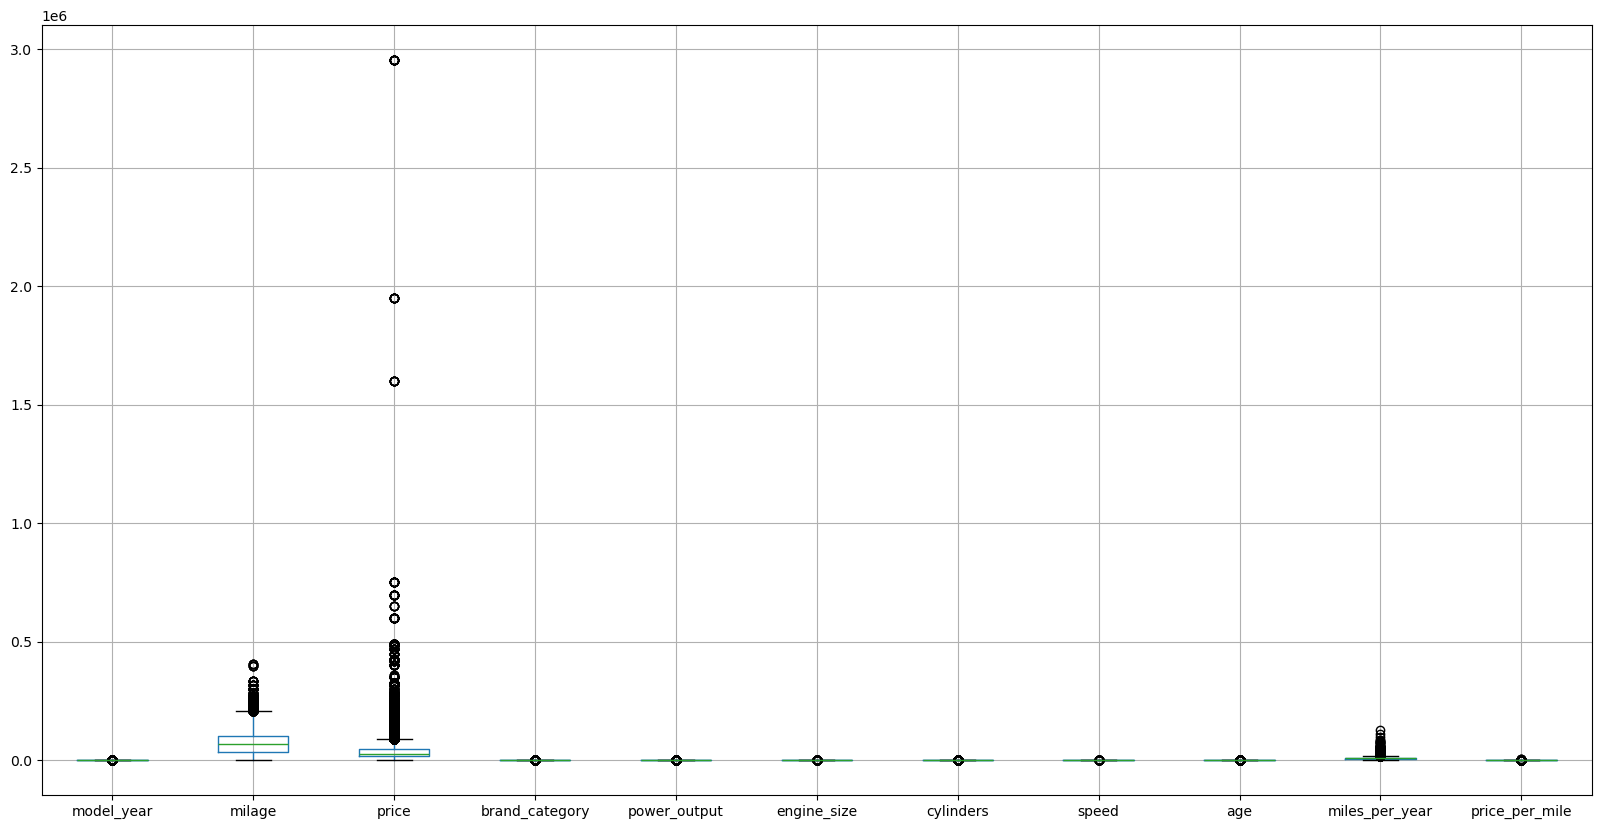

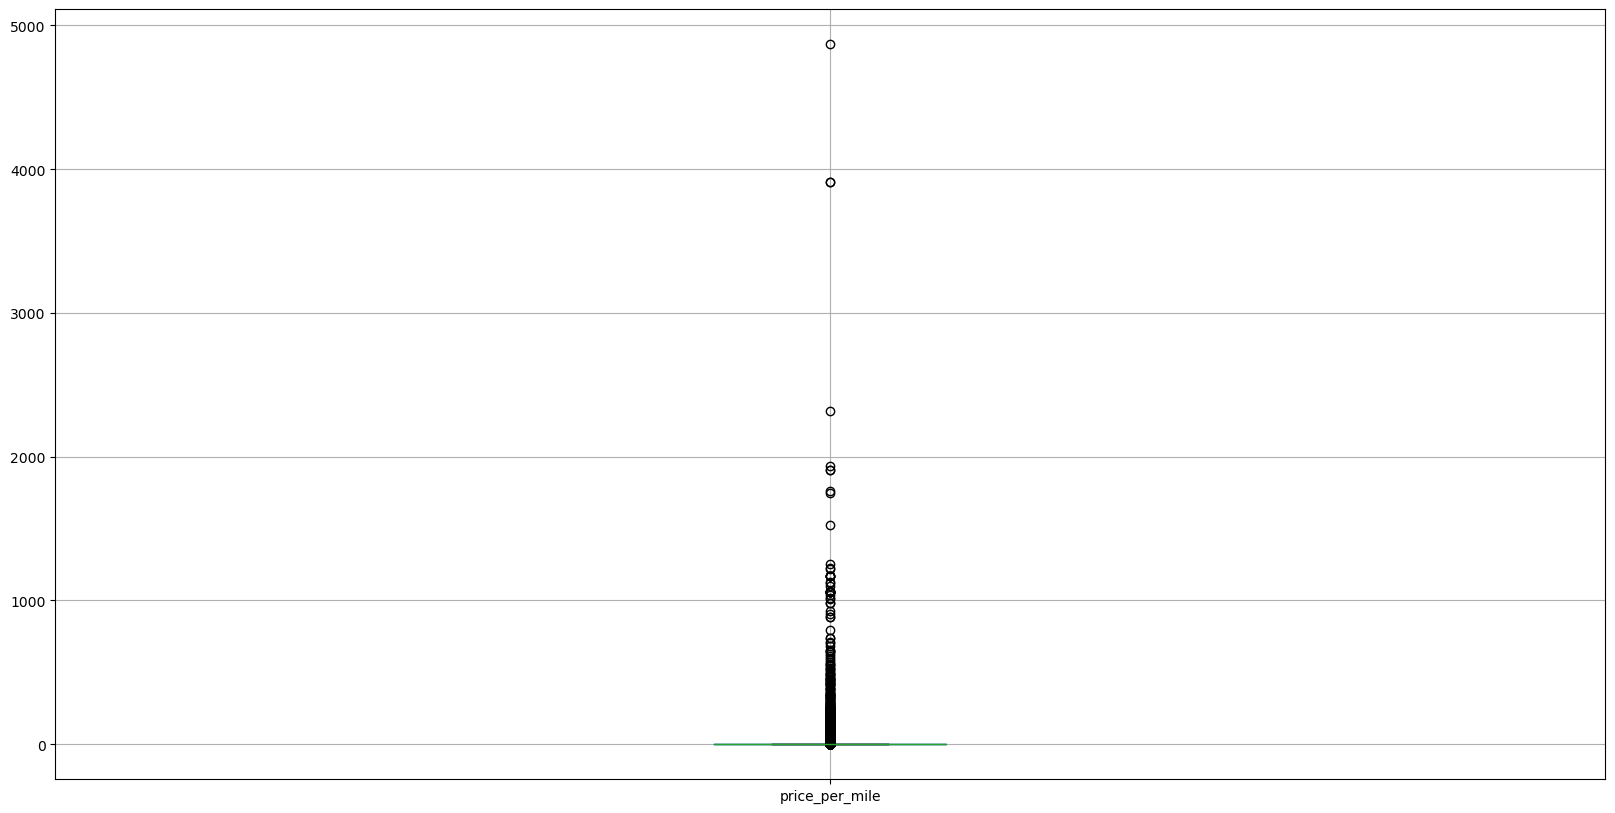

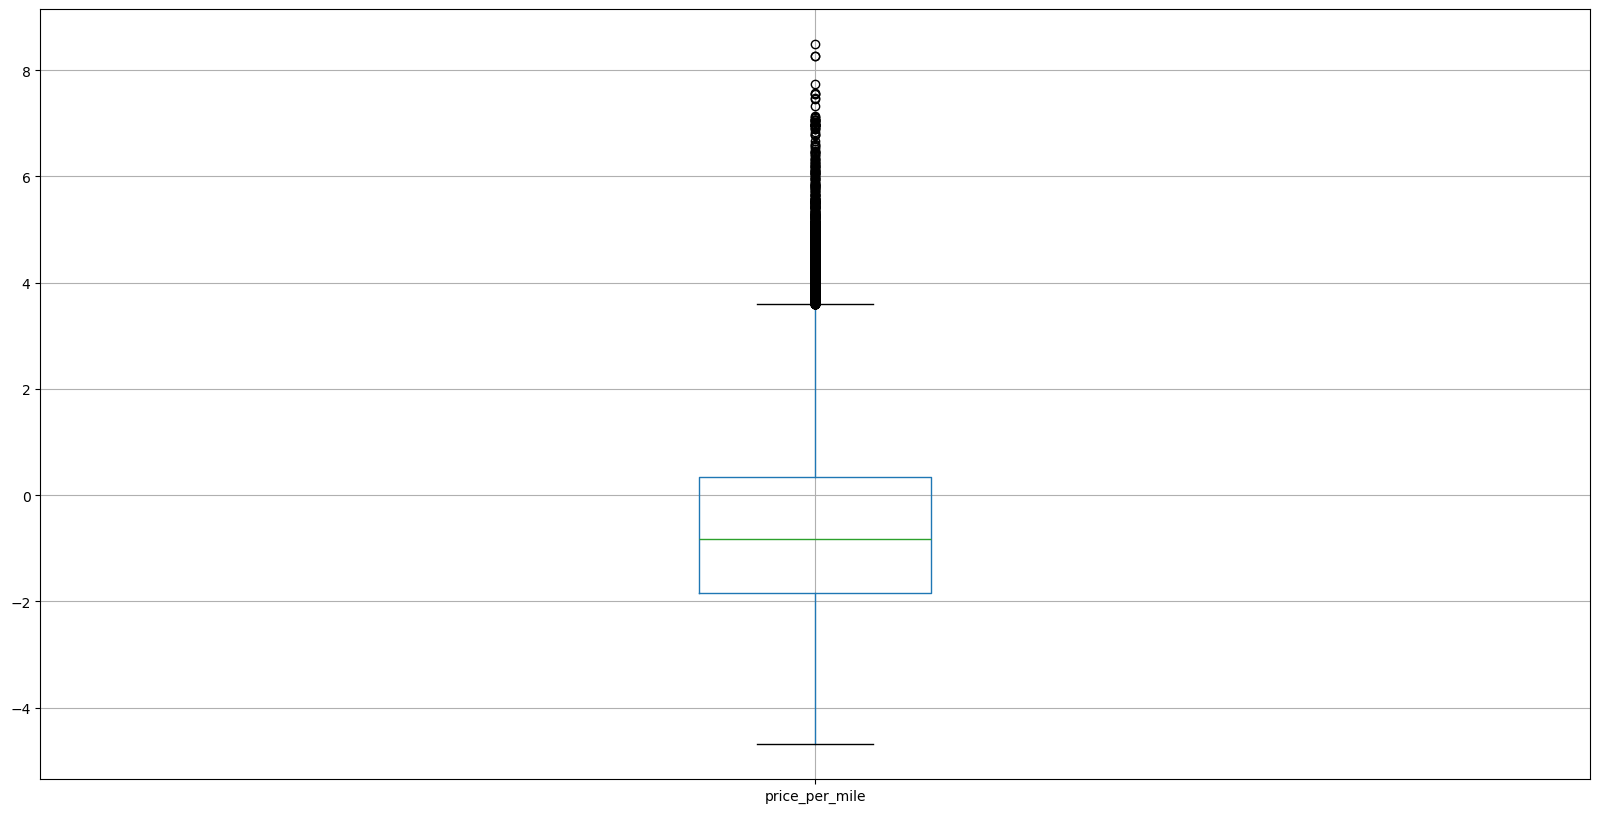

In [244]:
# identify outliers
df_train.boxplot(figsize=(20, 10))
plt.show()

df_train[['price_per_mile']].boxplot(figsize=(20, 10))
plt.show()

np.log(df_train[['price_per_mile']]).boxplot(figsize=(20, 10))
plt.show()

In [221]:
# Exclude outliers using iqr/z-score 
#df_train = df_train[~((df_train['price'] > 200000) & (df_train['brand_category'] == 1))]

from scipy.stats import zscore

# Define a function to calculate IQR and filter outliers
def remove_outliers_iqr(group):
    Q1 = group['price'].quantile(0.20)
    Q3 = group['price'].quantile(0.80)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['price'] >= lower_bound) & (group['price'] <= upper_bound)]

'''
# Define a function to calculate Z-scores and filter outliers
def remove_outliers(group):
    group['z_score'] = zscore(group['price'])
    return group[np.abs(group['z_score']) <= 3]
'''

# Apply the function to each group of brand and model
#filtered_df = 
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_train = df_train.groupby(['brand', 'model']).apply(remove_outliers_iqr).reset_index(drop=True)

# Drop the z_score column as it's no longer needed
#df_train = df_train.drop(columns=['z_score'])

#df_train.set_index('id', inplace=True)

df_train.head()


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic,age,miles_per_year,price_per_mile
0,27209,Acura,BRZ Limited,2013,70582,Gasoline,200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed M/T,White,Black,None reported,Yes,17900,3,Acura,200.00,2.00,4.00,6.00,Manual,white,black,12,5881.83,0.25
1,11434,Acura,Boxster S,2020,25000,Gasoline,280.0HP 3.2L Flat 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,White,Gray,None reported,Yes,35999,3,Acura,280.00,3.20,6.00,6.00,Manual,white,grey,5,5000.00,1.44
2,12270,Acura,Celica GT,2001,122000,Gasoline,140.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,5-Speed M/T,Blue,–,None reported,Yes,7800,3,Acura,140.00,1.80,4.00,5.00,Manual,blue,others,24,5083.33,0.06
3,22959,Acura,ES 350 Base,2007,78980,Gasoline,272.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Silver,Beige,At least 1 accident or damage reported,Yes,10600,3,Acura,272.00,3.50,6.00,6.00,Manual,silver,brown,18,4387.78,0.13
4,23411,Acura,Elantra SE,2010,153843,Gasoline,150.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,5-Speed M/T,Red,Beige,At least 1 accident or damage reported,Yes,9450,3,Acura,150.00,2.00,4.00,5.00,Manual,red,brown,15,10256.20,0.06


In [223]:
# print out the size of the data set
print("Shape of training set: ", df_train.shape)
print("Shape of testing set:", df_test.shape)

Shape of training set:  (51122, 25)
Shape of testing set: (36183, 23)


While the z-score reduced the number of outliers we still saw outliers in prices where regular cars like Toyota which are supposed to be priced arounf 30K-40K recorded at 115K. 

In [184]:
# review cars over 100K not in luxury category
df_train[(df_train['price'] < 3000) & 
         (df_train['brand_category']== 1)  ]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic,age,miles_per_year
id,,,,,,,,,,,,,,,,,,,,,,,
826,Chevrolet,Corvette Base,1998,158000,Gasoline,340.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,4-Speed A/T,White,Black,None reported,Yes,2500,1,Chevrolet,340.0,5.7,8.0,4.0,Automatic,white,black,27,5851.851852
4747,Chevrolet,Monte Carlo SS,2000,74000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,Red,Black,None reported,Yes,2500,1,Chevrolet,200.0,3.8,6.0,NaN,Automatic,red,black,25,2960.000000
6347,Pontiac,Firebird Trans Am,2001,91812,Gasoline,310.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,Yes,2300,1,other,310.0,5.7,8.0,NaN,Automatic,white,brown,24,3825.500000
6962,Chevrolet,Tahoe Base,2004,127941,Diesel,240.0HP 3.0L V6 Cylinder Engine Diesel Fuel,A/T,Red,Black,None reported,Yes,2300,1,Chevrolet,240.0,3.0,6.0,NaN,Automatic,red,black,21,6092.428571
11515,Chevrolet,Ram 1500 Laramie,2004,141209,Gasoline,345.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,2800,1,Chevrolet,345.0,5.7,8.0,NaN,Automatic,black,black,21,6724.238095
14308,Mitsubishi,Lancer Sportback ES,2001,74000,Gasoline,148.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,5-Speed M/T,Blue,Black,None reported,Yes,2300,1,other,148.0,2.0,4.0,5.0,Manual,blue,black,24,3083.333333
14871,Chevrolet,Monte Carlo SS,2000,67800,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,Red,Gray,None reported,Yes,2500,1,Chevrolet,200.0,3.8,6.0,NaN,Automatic,red,grey,25,2712.000000
16755,Chevrolet,Monte Carlo Supercharged SS,2000,140000,Gasoline,240.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,Red,–,None reported,Yes,2500,1,Chevrolet,240.0,3.8,6.0,NaN,Automatic,red,others,25,5600.000000
17417,Chevrolet,Cruze LS,2013,179200,Gasoline,136.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,A/T,Black,Black,At least 1 accident or damage reported,Yes,2500,1,Chevrolet,136.0,1.8,4.0,NaN,Automatic,black,black,12,14933.333333


In [9]:
df_train[(df_train['brand'] == "Toyota") & 
         (df_train['model']== "Tundra Platinum")  ]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,,,,,,,,
3847,Toyota,Tundra Platinum,2022,8800,Gasoline,389.0HP 3.4L V6 Cylinder Engine Gasoline Fuel,A/T,Green,Brown,None reported,Yes,68500,1,Toyota,389.0,3.4,6.0,NaN,Automatic,others,brown
3983,Toyota,Tundra Platinum,2019,34672,Gasoline,389.0HP 3.4L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Black,None reported,Yes,45999,1,Toyota,389.0,3.4,6.0,10.0,Automatic,blue,black
7214,Toyota,Tundra Platinum,2018,53750,Gasoline,389.0HP 3.4L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Black,None reported,Yes,39650,1,Toyota,389.0,3.4,6.0,10.0,Automatic,blue,black
8365,Toyota,Tundra Platinum,2018,66000,E85 Flex Fuel,381.0HP 5.7L 8 Cylinder Engine Flex Fuel Capability,6-Speed A/T,Gray,Black,None reported,Yes,49900,1,Toyota,381.0,5.7,8.0,6.0,Automatic,grey,black
8524,Toyota,Tundra Platinum,2018,66000,Gasoline,381.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Gray,Black,None reported,Yes,65000,1,Toyota,381.0,5.7,8.0,6.0,Automatic,grey,black
14258,Toyota,Tundra Platinum,2018,66000,Gasoline,381.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,52000,1,Toyota,381.0,5.7,8.0,NaN,Automatic,white,black
21952,Toyota,Tundra Platinum,2020,6600,Gasoline,381.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,75500,1,Toyota,381.0,5.7,8.0,NaN,Automatic,white,black
24305,Toyota,Tundra Platinum,2018,67865,Gasoline,389.0HP 3.4L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,At least 1 accident or damage reported,Yes,42500,1,Toyota,389.0,3.4,6.0,NaN,Automatic,white,black
25282,Toyota,Tundra Platinum,2023,15500,Gasoline,389.0HP 3.4L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,65000,1,Toyota,389.0,3.4,6.0,NaN,Automatic,blue,black


In [224]:
# summary statistics of numeric features
# price = target feature
df_train.describe()

,id,model_year,milage,price,brand_category,power_output,engine_size,cylinders,speed,age,miles_per_year,price_per_mile
count,51122.00,51122.00,51122.00,51122.00,51122.00,50686.00,50911.00,50515.00,50345.00,51122.00,51122.00,51122.00
mean,27133.00,2015.01,74003.94,33147.44,2.53,331.76,3.72,6.28,6.97,9.99,7580.50,3.60
std,15666.35,5.57,50281.09,33484.70,0.81,107.76,1.33,1.54,1.40,5.57,4459.53,32.68
min,0.00,1974.00,100.00,2000.00,1.00,76.00,0.65,3.00,1.00,1.00,5.75,0.01
25%,13564.25,2012.00,34672.00,15000.00,2.00,255.00,3.00,6.00,6.00,6.00,4764.60,0.15
50%,27132.50,2016.00,67500.00,26990.00,3.00,310.00,3.50,6.00,7.00,9.00,7232.06,0.41
75%,40698.50,2019.00,103400.00,42700.00,3.00,400.00,4.60,8.00,8.00,13.00,9727.27,1.22
max,54272.00,2024.00,405000.00,2954083.00,6.00,1020.00,8.40,12.00,10.00,51.00,125817.00,3913.00


In [225]:
df_test.describe()

,id,model_year,milage,brand_category,power_output,engine_size,cylinders,speed,age,miles_per_year
count,36183.00,36183.00,36183.00,36183.00,35873.00,36029.00,35745.00,35639.00,36183.00,36183.00
mean,72364.00,2015.06,72479.27,2.53,332.15,3.73,6.29,6.96,9.94,7443.73
std,10445.28,5.59,50714.97,0.81,108.78,1.34,1.55,1.40,5.59,4628.01
min,54273.00,1974.00,100.00,1.00,70.00,0.65,3.00,1.00,1.00,11.67
25%,63318.50,2012.00,31681.00,2.00,255.00,3.00,6.00,6.00,6.00,4556.25
50%,72364.00,2016.00,65680.00,3.00,310.00,3.50,6.00,7.00,9.00,7091.25
75%,81409.50,2019.00,102000.00,3.00,400.00,4.60,8.00,8.00,13.00,9664.29
max,90455.00,2024.00,405000.00,6.00,835.00,8.40,12.00,10.00,51.00,161894.00


In [226]:
# model: too many unique values @ 1827
# engine: too many unique values -> can be broken down with NLP 
# transmission: can be broken down with NLP
# ext_col and int_col: too many values?

# clean_title: redundant feature since only one value present

df_train.describe(include=["object", "bool"])

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,top_brand,transmission_type,ext_color_basic,int_color_basic
count,51122,51122,51122,51122,51122,51122,51122,51122,51122,51122,51122,51122,51122
unique,53,1827,6,1059,46,256,123,2,1,25,5,8,8
top,BMW,F-150 XLT,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,BMW,Automatic,black,black
freq,6972,745,46547,1373,15937,14211,29906,37297,51122,6972,39761,14822,30736


In [227]:
df_test.describe(include=["object", "bool"])

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,top_brand,transmission_type,ext_color_basic,int_color_basic
count,36183,36183,36183,36183,36183,36183,36183,36183,36183,36183,36183,36183,36183
unique,53,1791,6,1038,44,230,111,2,1,25,5,8,8
top,BMW,F-150 XLT,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,BMW,Automatic,black,black
freq,4854,496,33033,886,11273,10027,21122,26598,36183,4854,28052,10443,21710


In [228]:
# check for duplicates
num_duplicates = df_train.duplicated().sum()

if num_duplicates !=0:
    print(f'There are {num_duplicates} duplicate rows, removing them from the data.')
    df_train.drop_duplicates(inplace=True)
else:
    print(f'{num_duplicates} duplicate rows detected.')

0 duplicate rows detected.


In [229]:
# check for missing values
def check_missing_values(df):
    missing_columns = [col for col in df.columns if df[col].isnull().any()]
    missingvalues_count =df.isna().sum()
    missingValues_df = pd.DataFrame(missingvalues_count.rename('Missing Values')).loc[missingvalues_count.ne(0)]
    missingValues_df['Percentage'] = missingValues_df['Missing Values'] * 100 / df.shape[0]
    return missingValues_df

df = check_missing_values(df_train)
print(df.sort_values(by='Missing Values', ascending=False))

              Missing Values  Percentage
speed                    777        1.52
cylinders                607        1.19
power_output             436        0.85
engine_size              211        0.41


In [198]:
# "imputing" missing values based on brand and model grouping
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

# Combine df_train and df_test to calculate the average speed
combined_df = pd.concat([df_train, df_test])

# Group by 'brand' and 'model' and calculate the average values, ignoring NaN values
grouped_df = combined_df.groupby(['brand', 'model']).agg({
    'speed': 'mean',
    'cylinders': 'mean',
    'power_output': 'mean',
    'engine_size': 'mean'
}).reset_index()

# Define a function to merge and update values for the given columns
def update_columns(df, grouped_df, columns):
    # Merge on ['brand', 'model'] and preserve original index
    df_merged = df.merge(grouped_df, 
                         how='left',
                         #left_index=True, right_index=True,
                         on=['brand', 'model'], suffixes=('', '_mean')  )#.reset_index().set_index('id')

    #df1.merge(df2, how="inner", left_index=True, right_index=True)
    for col in columns:
        df_merged[col] = df_merged.apply(lambda row: row[f'{col}_mean'] if pd.isna(row[col]) else row[col], axis=1)
    return df_merged.drop(columns=[f'{col}_mean' for col in columns])

# List of columns to update
columns_to_update = ['speed', 'cylinders', 'power_output', 'engine_size']

# Update columns in both df_train and df_test
df_train = update_columns(df_train, grouped_df, columns_to_update)
df_test = update_columns(df_test, grouped_df, columns_to_update)

#df_train.set_index('id', inplace=True)

df = check_missing_values(df_train)
print(df.sort_values(by='Missing Values', ascending=False))

              Missing Values  Percentage
speed                    822        1.51
cylinders                654        1.21
power_output             470        0.87
engine_size              230        0.42


In [200]:
df_train = df_train.set_index('id')#.drop(columns='index', axis=1, inplace=True)
df_test = df_test.set_index('id')#.drop(columns='index', axis=1, inplace=True)
#grouped_df
df_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic,age,miles_per_year
id,,,,,,,,,,,,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000,2,Ford,375.00,3.50,6.00,10.00,Automatic,blue,grey,7,10621.29
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,8250,3,BMW,300.00,3.00,6.00,6.00,Manual,black,black,18,4444.44
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000,3,Jaguar,300.00,4.20,8.00,6.00,Automatic,others,brown,16,5718.19
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500,3,BMW,335.00,3.00,6.00,7.99,AM,grey,brown,3,812.33
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850,1,other,200.00,3.80,6.00,4.18,Automatic,white,black,24,4625.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54268,BMW,X6 xDrive50i,2017,29000,Gasoline,445.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Brown,None reported,Yes,29000,3,BMW,445.00,4.40,8.00,8.00,Automatic,white,brown,8,3625.00
54269,Audi,A4 2.0T Premium,2015,94634,E85 Flex Fuel,220.0HP 2.0L 4 Cylinder Engine Flex Fuel Capability,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,6500,3,Audi,220.00,2.00,4.00,6.00,Automatic,black,black,10,9463.40
54270,Porsche,Cayenne S,2013,40989,Gasoline,420.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Black,At least 1 accident or damage reported,Yes,18950,4,Porsche,420.00,3.60,6.00,7.75,AM,white,black,12,3415.75


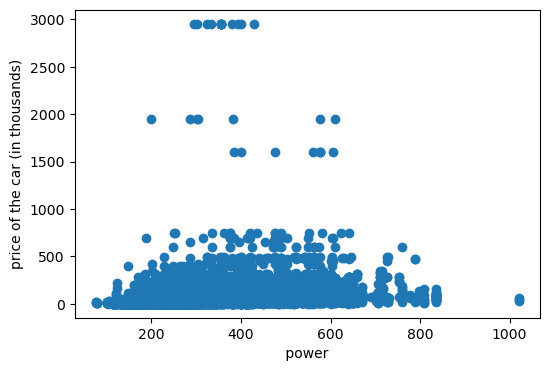

In [213]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df_train['power_output'], df_train['price']/1000)
ax.set_xlabel(' power ')
ax.set_ylabel('price of the car (in thousands)')
plt.show()

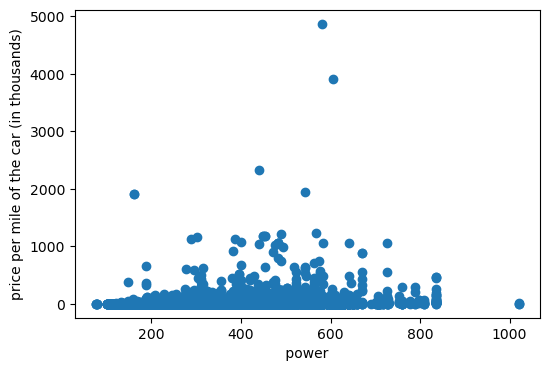

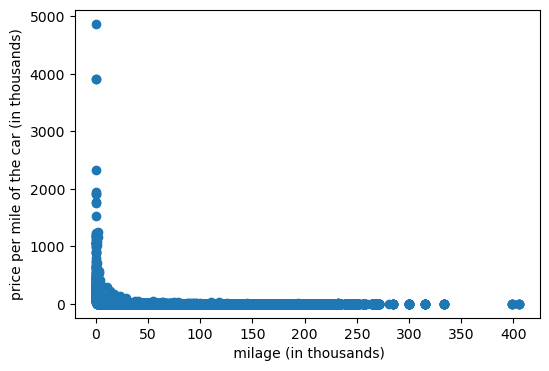

In [220]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df_train['power_output'], df_train['price_per_mile'])
ax.set_xlabel(' power ')
ax.set_ylabel('price per mile of the car (in thousands)')
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df_train['milage']/1000, df_train['price_per_mile'])
ax.set_xlabel(' milage (in thousands)')
ax.set_ylabel('price per mile of the car (in thousands)')
plt.show()



### Dropping columns 

modified columns: engine, transmission, ext_col, int_col, 

missing values: aspiration, valves, cylinder_layout, 

redundunt: clean_title , 



In [150]:
## drop columns
col_to_drop = [ 'engine', 'transmission', 'ext_col', 'int_col', 'brand',
               #'aspiration', 'valves', 'cylinder_layout', 
               'clean_title', 'model']

df_train.drop(columns=col_to_drop, axis=1, inplace=True)
df_test.drop(columns=col_to_drop, axis=1, inplace=True)

df_train.head()

,model_year,milage,fuel_type,accident,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,
27209,2013,70582,Gasoline,None reported,17900,2,other,200.0,2.0,4.0,6.0,Manual,white,black
11434,2020,25000,Gasoline,None reported,35999,2,other,280.0,3.2,6.0,6.0,Manual,white,grey
12270,2001,122000,Gasoline,None reported,7800,2,other,140.0,1.8,4.0,5.0,Manual,blue,others
22959,2007,78980,Gasoline,At least 1 accident or damage reported,10600,2,other,272.0,3.5,6.0,6.0,Manual,silver,brown
23411,2010,153843,Gasoline,At least 1 accident or damage reported,9450,2,other,150.0,2.0,4.0,5.0,Manual,red,brown


In [152]:
# get a list of categorical and numerical variables
categorical_features = list(df_train.select_dtypes(include=['object', 'category']).columns)
numerical_features = list(df_train.select_dtypes(include=['float64', 'int64']).columns)
#numerical_features.remove('index')
numerical_features.remove('price')
target_feature = 'price'


# print out the size of the data set
print("Shape of training set: ", df_train.shape)
print("Shape of testing set:", df_test.shape)

Shape of training set:  (51122, 14)
Shape of testing set: (36183, 13)


In [15]:
# Plotting the categorical variables in training and testing sets: ordered
# Define the function to plot the categorical variables
def count_plot(var, dataframe1, dataframe2):
    # Concatenate the two dataframes for the variable
    combined_data = pd.concat([dataframe1[var], dataframe2[var]]).dropna()
    
    # Determine the order of categories based on frequency
    category_order = combined_data.value_counts().index
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 
    
    # Plot training data
    sns.countplot(y=var, data=dataframe1, ax=axes[0], order=category_order)
    axes[0].set_title(f'Training Set - {var}')
    
    # Plot testing data
    sns.countplot(y=var, data=dataframe2, ax=axes[1], order=category_order)
    axes[1].set_title(f'Testing Set - {var}')
    
    plt.tight_layout()
    plt.show()

# Define a function for interactive plotting
def inter_cat_plot(x):
    return count_plot(x, df_train, df_test)


# Create a dropdown widget for selecting the categorical variable
widget_cat_plot = widgets.Dropdown(
    options=categorical_features,
    description="Categorical Variable:", 
    style=style
)

# Use interact to create an interactive plot
interact(inter_cat_plot, x=widget_cat_plot)

interactive(children=(Dropdown(description='Categorical Variable:', options=('fuel_type', 'accident', 'top_bra…

<function __main__.inter_cat_plot(x)>

In [119]:
# Plot numerical variables:

### Histogram plot function to display numerical features ###
def histogram_plot(var, dataframe1, dataframe2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True) # Share both axes for comparison
    sns.histplot(dataframe1[var].dropna(), ax=axes[0], kde=True, element="step", color="skyblue", bins=10)
    axes[0].set_title(f'Training Set - {var}')
    sns.histplot(dataframe2[var].dropna(), ax=axes[1], kde=True, element="step", color="orange", bins=10)
    axes[1].set_title(f'Testing Set - {var}')
    plt.tight_layout()
    plt.show()

def inter_num_plot(x):
    return histogram_plot(x, df_train, df_test)

### Multiple selection widgets for interactive plotting ###
widget_num_plot = widgets.Dropdown(
    options=numerical_features,
    description="Numerical Variable:", 
    style=style
)

interact(inter_num_plot, x=widget_num_plot)

interactive(children=(Dropdown(description='Numerical Variable:', options=('model_year', 'milage', 'brand_cate…

<function __main__.inter_num_plot(x)>

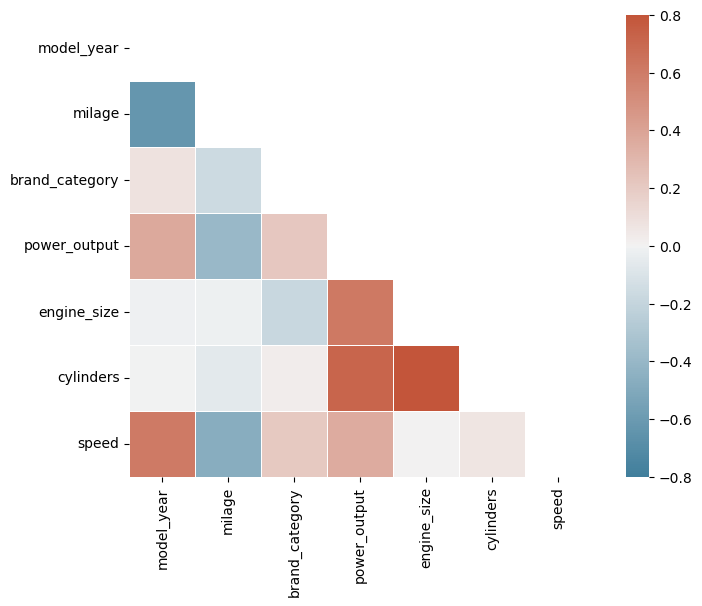

In [122]:
# Calculate correlation matrix 
# Check parameters: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html 
corr = df_train[numerical_features].corr() # method='pearson', 'kendall' , 'spearman'

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9,6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-0.8,vmax=0.8, square=True, linewidths=.5)
plt.show()

## Feature engineering



### Missing values to deal with:

speed: 46%

cylinders: 37%

power output: 7%

engine_size: 1%


Can we get this information based on the {brand , model, model_year, fuel_type, transmission_type , power_output}. 



model: too many unique values @ 1827


In [153]:
# impute the missing values:

# Combine train and test datasets to ensure consistency in imputation
#df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# Convert numeric columns to appropriate numeric types
columns_to_impute = ['speed', 'cylinders', 'power_output', 'engine_size']
#group_col = ['brand', 'model', 'transmission_type',  'model_year' ] #, 'fuel_type'

# Calculate the mean of columns_to_impute by grouping using group_col
#imputation_means = df_combined.groupby(group_col)[columns_to_impute].mean()

# Filling speed column with mean of Count column
#df_train.fillna(dataframe['speed'].mean(), inplace = True)

# Calculate mean for each column in df_train
impute_values = df_train[columns_to_impute].mean()


# Impute missing values in df_train
df_train_imputed  = df_train.fillna(impute_values, inplace=False)

# Impute missing values in df_test using the same impute_values
df_test_imputed = df_test.fillna(impute_values, inplace=False)



#df_train.groupby(group_col)['speed'].transform(lambda x: x.fillna(x.mean()))


In [154]:
# Plot numerical variables: imputed data

### Histogram plot function to display numerical features ###
def histogram_plot(var, dataframe1, dataframe2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True) # Share both axes for comparison
    sns.histplot(dataframe1[var].dropna(), ax=axes[0], kde=True, element="step", color="skyblue", bins=10)
    axes[0].set_title(f'Training Set - {var}')
    sns.histplot(dataframe2[var].dropna(), ax=axes[1], kde=True, element="step", color="orange", bins=10)
    axes[1].set_title(f'Testing Set - {var}')
    plt.tight_layout()
    plt.show()

def inter_num_plot(x):
    return histogram_plot(x, df_train_imputed, df_test_imputed)

### Multiple selection widgets for interactive plotting ###
widget_num_plot = widgets.Dropdown(
    options=numerical_features,
    description="Numerical Variable:", 
    style=style
)

interact(inter_num_plot, x=widget_num_plot)

interactive(children=(Dropdown(description='Numerical Variable:', options=('model_year', 'milage', 'brand_cate…

<function __main__.inter_num_plot(x)>

In [155]:

df = check_missing_values(df_test_imputed)
print(df.sort_values(by='Missing Values', ascending=False))

Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


In [156]:
df_train_imputed

,model_year,milage,fuel_type,accident,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,
27209,2013,70582,Gasoline,None reported,17900,2,other,200.0,2.0,4.0,6.000000,Manual,white,black
11434,2020,25000,Gasoline,None reported,35999,2,other,280.0,3.2,6.0,6.000000,Manual,white,grey
12270,2001,122000,Gasoline,None reported,7800,2,other,140.0,1.8,4.0,5.000000,Manual,blue,others
22959,2007,78980,Gasoline,At least 1 accident or damage reported,10600,2,other,272.0,3.5,6.0,6.000000,Manual,silver,brown
23411,2010,153843,Gasoline,At least 1 accident or damage reported,9450,2,other,150.0,2.0,4.0,5.000000,Manual,red,brown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51848,2018,110380,Gasoline,At least 1 accident or damage reported,31000,2,other,316.0,2.0,4.0,8.000000,Automatic,white,brown
52127,2018,60660,Gasoline,None reported,26000,2,other,316.0,2.0,4.0,8.000000,Automatic,white,black
53219,2017,66500,Gasoline,At least 1 accident or damage reported,22500,2,other,316.0,2.0,4.0,8.000000,Automatic,silver,grey


In [157]:
# Spliting the dataset.
Y = np.log(df_train_imputed[target_feature]) # transform the price to log(price)
X = df_train_imputed.drop(columns=[target_feature])

X_train, X_val,y_train,y_val = train_test_split(X, Y, test_size=0.20, random_state=5)

Cat: ['brand',
 'fuel_type',
 'accident',
 'brand_category',
 'transmission_type',
 'ext_color_basic',
 'int_color_basic']


 Num: ['model_year', 'milage', 'power_output', 'engine_size', 'cylinders']

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


one_hot_features = ['top_brand', 'fuel_type','transmission_type', 'ext_color_basic','int_color_basic' ,
                    'brand_category'] 
#label_encode_features = ['brand_category'] 
dummy_encode_features = ['accident'] 

# Function for dummy encoding
def dummy_encode(df):
    return pd.get_dummies(df, drop_first=True)

# Define the preprocessing for each column type
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('onehot', OneHotEncoder(), one_hot_features),
        ('dummy', FunctionTransformer(dummy_encode, validate=False), dummy_encode_features)
    ],
    remainder='passthrough'
)
'''
# Label encode separately as it needs to fit on the entire column
for col in label_encode_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
   # df_test_imputed[col] = le.transform(df_test_imputed[col])
'''

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f'R-squared: {r2}')
print(f'RMSE: {rmse}')

R-squared: 0.6819366056151217
RMSE: 0.42899778644708286


In [159]:
y_test_pred = pipeline.predict(df_test_imputed)
y_test_pred

y_hat_data = df_test_imputed.copy(deep = True)
y_hat_data['price_lm'] = np.exp( y_test_pred)

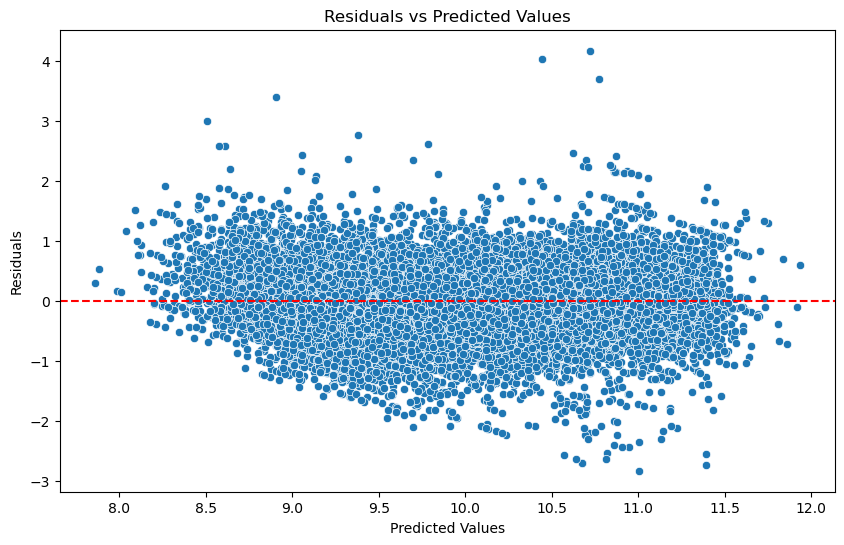

In [160]:
# residual analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the training set to analyze residuals
y_train_pred = pipeline.predict(X_train)

# Residuals
residuals = y_train - y_train_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred, y=residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(0, color='red', linestyle='--')
plt.show()


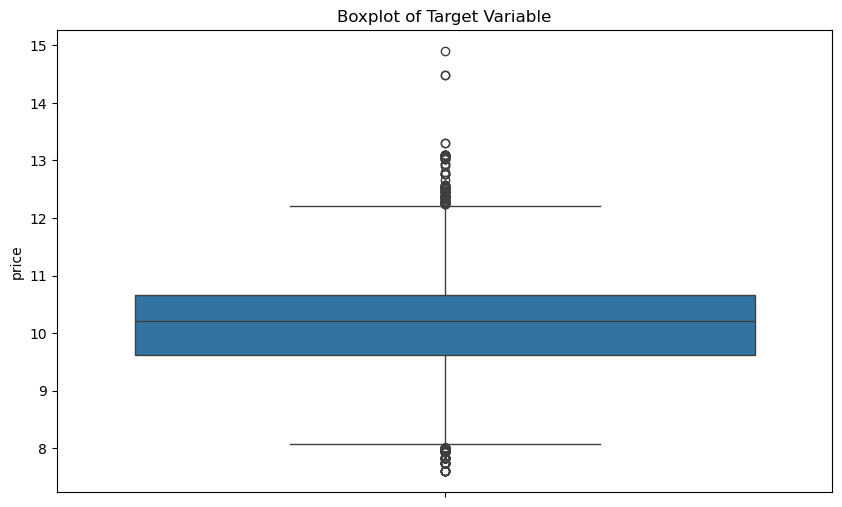

In [161]:
# outliers:
# Box plot to identify outliers in target variable
plt.figure(figsize=(10, 6))
sns.boxplot(y=y_train)
plt.title('Boxplot of Target Variable')
plt.show()


In [162]:
# model complexity

# Calculate training RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Print train and validation scores
print(f'Training RMSE: {train_rmse}')
print(f'Validation RMSE: {rmse}')
print(f'Training R-squared: {r2_score(y_train, y_train_pred)}')
print(f'Validation R-squared: {r2}')


Training RMSE: 0.4289302555248152
Validation RMSE: 0.42899778644708286
Training R-squared: 0.6856303444671104
Validation R-squared: 0.6819366056151217


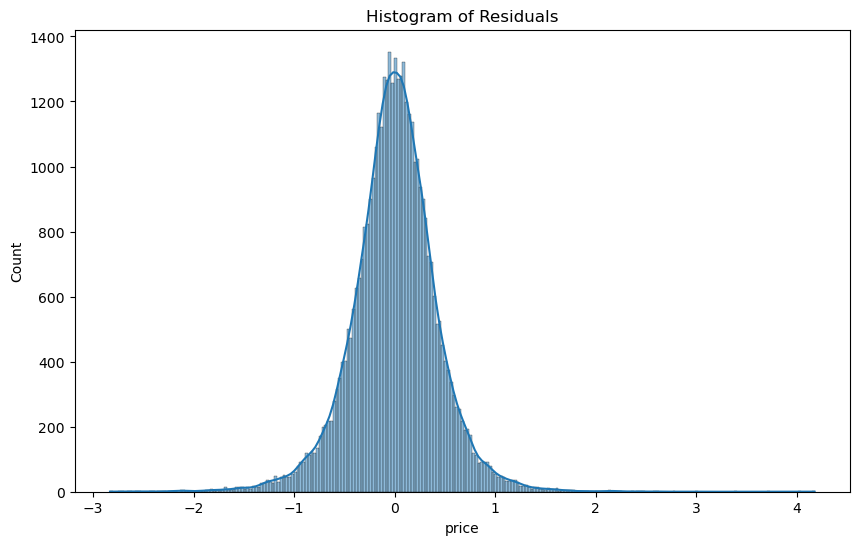

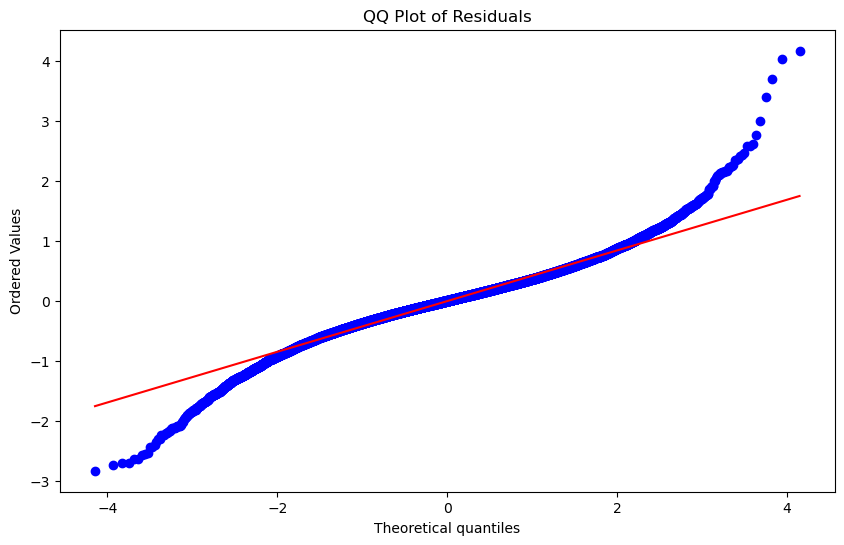

In [163]:
# Check normality of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# QQ plot
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()


In [164]:
# Train and save multiple models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import joblib


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Gradient Boost Regressor": GradientBoostingRegressor(random_state=42, learning_rate=0.05, loss="squared_error")
    #"SVR": SVR()
}

best_model = None
best_score = float('-inf')
best_model_name = ""

for name, model in models.items():
    model.fit(preprocessor.transform(X_train), y_train)
    y_pred = model.predict(preprocessor.transform(X_val))
    r2 = r2_score(y_val, y_pred)
    print(f"{name} R^2 score: {r2}")
    if r2 > best_score:
        best_score = r2
        best_model = model
        best_model_name = name

# Save the best model
joblib.dump(best_model, 'best_model.pkl')

print(f"Best model: {best_model_name} with R^2 score: {best_score}")


Linear Regression R^2 score: 0.6819366056151217
Random Forest R^2 score: 0.7105957829701527
XGBoost R^2 score: 0.7202677736341507
Gradient Boost Regressor R^2 score: 0.7096942519998448
Best model: XGBoost with R^2 score: 0.7202677736341507


## Hyperparameter Tuning

In [140]:
from sklearn.model_selection import RandomizedSearchCV

# Define the models and hyperparameter grids
models = {
    "Linear Regression": (LinearRegression(), {}),
    "Random Forest": (RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30, 40, 50]
    }),
    "XGBoost": (XGBRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.1, 0.2, 0.3]
    })
    # SVR is too heavy for tuning...
}

best_model = None
best_score = float('-inf')
best_model_name = ""

for name, (model, param_grid) in models.items():
    if param_grid:
        search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, scoring='r2', random_state=42, n_jobs=-1)
        search.fit(preprocessor.transform(X_train), y_train)
        best_model_for_name = search.best_estimator_
    else:
        best_model_for_name = model
        best_model_for_name.fit(preprocessor.transform(X_train), y_train)
    
    y_pred = best_model_for_name.predict(preprocessor.transform(X_val))
    r2 = r2_score(y_val, y_pred)
    print(f"{name} R^2 score: {r2}")
    if r2 > best_score:
        best_score = r2
        best_model = best_model_for_name
        best_model_name = name

# Save the best model and its name
joblib.dump(best_model, 'hypertuned_best_model.pkl')

print(f"Best model: {best_model_name} with R^2 score: {best_score}")



Linear Regression R^2 score: 0.6091838997337604
Random Forest R^2 score: 0.646582602587013
XGBoost R^2 score: 0.6481680302276254
Best model: XGBoost with R^2 score: 0.6481680302276254


In [165]:
# Load the test data, make predictions, and save the results
df_test_imputed_transformed = preprocessor.transform(df_test_imputed)
predictions = best_model.predict(df_test_imputed_transformed)
results = pd.DataFrame({
    'price': predictions
})

# Save results to a CSV file
#results.to_csv('../datasets/predictions.csv', index=False)
#print("Predictions saved to predictions.csv")

In [166]:
results
y_hat_data['price_xgb'] = np.exp(predictions)
#y_hat_data
#df_train_imputed[df_train_imputed['brand']=='Saab']

In [167]:
# add 'ensemble'
y_hat_data['price_mix'] = (y_hat_data['price_lm'] + y_hat_data['price_xgb'])/2
y_hat_data

,model_year,milage,fuel_type,accident,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic,price_lm,price_xgb,price_mix
id,,,,,,,,,,,,,,,,
54273,2014,73000,Gasoline,None reported,3,Mercedes-Benz,302.0,3.5,6.0,7.173529,Automatic,white,brown,23503.142645,19982.492188,21742.817416
54274,2015,128032,Gasoline,None reported,3,Lexus,275.0,3.5,6.0,8.000000,Automatic,silver,black,18786.859870,18040.835938,18413.847904
54275,2015,51983,Gasoline,None reported,3,Mercedes-Benz,241.0,2.0,4.0,7.000000,Automatic,blue,white,25727.268485,26452.992188,26090.130336
54276,2018,29500,Gasoline,At least 1 accident or damage reported,2,Land,518.0,5.0,8.0,7.974359,AM,white,white,54653.765312,50334.046875,52493.906094
54277,2020,90000,Gasoline,At least 1 accident or damage reported,3,BMW,335.0,3.0,6.0,8.000000,Automatic,white,black,28153.846295,33675.062500,30914.454397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90451,2019,4500,Gasoline,None reported,1,GMC,420.0,6.2,8.0,10.000000,Automatic,grey,black,57132.610962,52227.937500,54680.274231
90452,2004,185000,Gasoline,At least 1 accident or damage reported,1,Chevrolet,295.0,5.3,8.0,4.000000,Automatic,red,grey,6588.995376,7729.141602,7159.068489
90453,2011,116000,Gasoline,None reported,1,Toyota,132.0,1.8,4.0,5.000000,Manual,brown,grey,11899.400192,9799.973633,10849.686913


In [168]:
# saving the predictions to csv
y_hat_data['price_lm'].to_csv('../datasets/predictions_lm_3.csv')
y_hat_data['price_xgb'].to_csv('../datasets/predictions_xgb_3.csv')
y_hat_data['price_mix'].to_csv('../datasets/predictions_mix_3.csv')
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


Sources:

https://www.kaggle.com/competitions/kagglex-cohort4/overview

https://www.kaggle.com/code/saadatkhalid/laptop-price-prediction-eda-model-app

